In [1]:
from sklearn import datasets
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Data

In [2]:
iris = datasets.load_iris()
X = iris.data
X = (X-X.mean(axis=0))/X.std(axis=0)
np.corrcoef(X.T)

array([[ 1.        , -0.11756978,  0.87175378,  0.81794113],
       [-0.11756978,  1.        , -0.4284401 , -0.36612593],
       [ 0.87175378, -0.4284401 ,  1.        ,  0.96286543],
       [ 0.81794113, -0.36612593,  0.96286543,  1.        ]])

In [3]:
x, y = X[:,2], X[:,3]

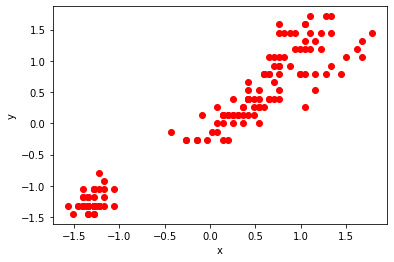

In [4]:
plt.scatter(x,y, color="red")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# GP

#### define kernel

In [5]:
def squared_exponential_kernel(a, b, sigma=1, l=1):
    sqdist = np.subtract.outer(a, b)**2
    cov = sigma**2 * np.exp(-0.5 * sqdist / l**2)
    return cov.squeeze()

#### define posterior distribution function

In [6]:
def posterior(x_star, x, y):
    N = x.shape[0]
    N_star = x_star.shape[0]
    K = (squared_exponential_kernel(x, x)+1e-6*np.eye(N)).reshape(N, N)
    K_star = squared_exponential_kernel(x_star, x).reshape(N_star, N)
    K_star_star = squared_exponential_kernel(x_star, x_star).reshape(N_star, N_star)
    CK = np.linalg.inv(K).dot(K_star.T)
    mu_new = CK.T.dot(y)
    K_new = K_star_star - K_star.dot(CK) + 1e-6*np.eye(N_star)
    return mu_new.squeeze(), K_new.squeeze()

#### prediction i.e. mean and sd for each new points in an array

In [7]:
def standar_deviation(x_star, x, y):
    std = np.transpose([posterior(np.array(i).reshape(1,1), x, y) for i in x_star])[1]
    return std

# draw sample from posterior distribution

#### let's see some example

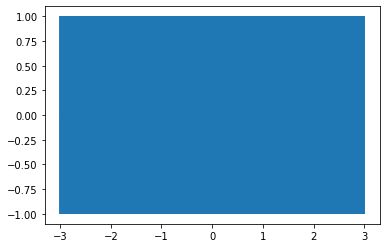

In [8]:
x_star = np.linspace(-3,3,1000)
plt.errorbar(x_star, np.zeros(len(x_star)), yerr=squared_exponential_kernel(0,0), capsize=0)
plt.show()

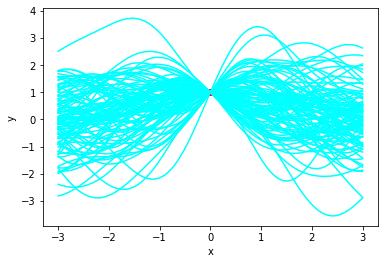

In [9]:
x0 = np.array([0])
y0 = np.array([1])
x0_star = np.linspace(-3,3,1000)
sample_draw = 100
mu0_star, K0_star = posterior(x0_star, x0, y0)

f0_prior = np.random.multivariate_normal(mean=mu0_star, cov=K0_star, size=sample_draw).T
plt.plot(x0_star, f0_prior, color="cyan")
plt.scatter(x0, y0, color="red")
plt.xlabel("x")
plt.ylabel("y")
plt.show();

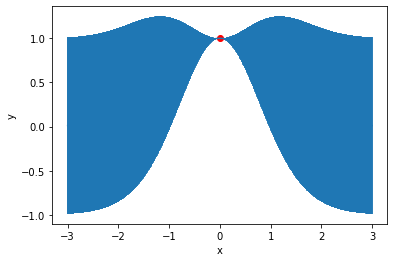

In [10]:
std0_star = standar_deviation(x0_star, x0, y0)
plt.errorbar(x0_star, mu0_star, yerr=std0_star, capsize=0)
plt.scatter(x0, y0, color="red")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

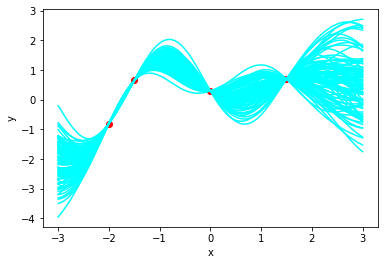

In [11]:
x1 = np.array([-2, -1.5, 0, 1.5])
y1 = np.array([-0.8, 0.65, 0.3, 0.7])
x1_star = np.linspace(-3,3,1000)
sample_draw = 100
mu1_star, K1_star = posterior(x_star, x1, y1)

f1_prior = np.random.multivariate_normal(mean=mu1_star, cov=K1_star, size=sample_draw).T
plt.scatter(x1, y1, color="red")
plt.plot(x1_star, f1_prior, color="cyan")
plt.xlabel("x")
plt.ylabel("y")
plt.show();

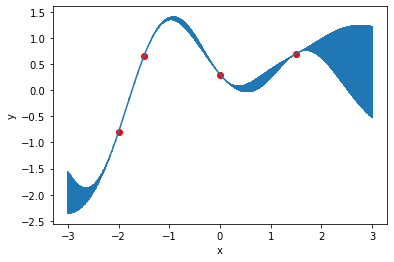

In [12]:
std1_star = standar_deviation(x1_star, x1, y1)
plt.errorbar(x1_star, mu1_star, yerr=std1_star, capsize=0)
plt.scatter(x1, y1, color="red")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# gp on whole data

C:\Users\smrut\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  after removing the cwd from sys.path.


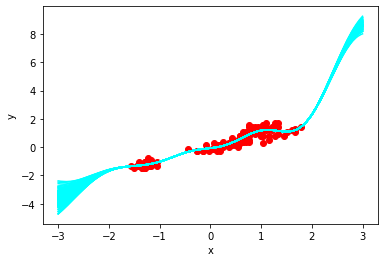

In [13]:
mu_star, K_star = posterior(x_star, x, y)
x_star = np.linspace(-3,3,1000)

f_prior = np.random.multivariate_normal(mean=mu_star, cov=K_star, size=sample_draw).T
plt.scatter(x, y, color="red")
plt.plot(x_star, f_prior, color="cyan")
plt.xlabel("x")
plt.ylabel("y")
plt.show();

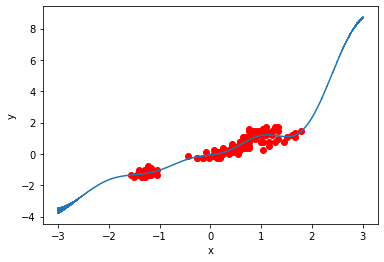

In [14]:
std_star = standar_deviation(x_star, x, y)
plt.errorbar(x_star, mu_star, yerr=std_star, capsize=0)
plt.scatter(x, y, color="red")
plt.xlabel("x")
plt.ylabel("y")
plt.show()